In [ ]:
!pip install -q kaggle
!pip install Pillow
!pip install opencv-python
!pip install matplotlib
!pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
! pip install visualkeras numpy pandas seaborn tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import autoviz
import time
import os
import csv
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import tflite_runtime.interpreter as tflite
import visualkeras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip /content/plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [ ]:
dataset_path = "/content/plantvillage dataset/color"

In [ ]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def split_data(data_dir):
  files, classes = define_paths(data_dir)
  data_df = define_df(files, classes)
  strat = data_df['labels']
  train_df, dummy_df = train_test_split(data_df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
  strat = dummy_df['labels']
  valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)
  return train_df, valid_df, test_df, data_df

In [ ]:
input_shape = (224,224,3)
batch_size = 40

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    tr_gen = ImageDataGenerator(horizontal_flip=True)
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                          class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size,)
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                          class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size,)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                          class_mode='categorical', color_mode=color, shuffle=False,
                                          batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 8)

    plt.figure(figsize= (18, 9))

    for i in range(sample):
        plt.subplot(2, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.suptitle('Sample of Training Data', fontsize=30, color='green')
    plt.show()

In [ ]:
train_df, valid_df, test_df, data_df = split_data(dataset_path)
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


In [ ]:
classes = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

for clss in classes:
    print(clss)

Apple___Cedar_apple_rust
Potato___Early_blight
Grape___healthy
Cherry_(including_sour)___Powdery_mildew
Corn_(maize)___Common_rust_
Tomato___Leaf_Mold
Peach___Bacterial_spot
Apple___healthy
Tomato___Bacterial_spot
Apple___Black_rot
Soybean___healthy
Potato___Late_blight
Apple___Apple_scab
Tomato___Septoria_leaf_spot
Pepper,_bell___Bacterial_spot
Strawberry___Leaf_scorch
Cherry_(including_sour)___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Tomato___Early_blight
Potato___healthy
Squash___Powdery_mildew
Grape___Black_rot
Corn_(maize)___Northern_Leaf_Blight
Grape___Esca_(Black_Measles)
Tomato___healthy
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Corn_(maize)___healthy
Strawberry___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Tomato___Target_Spot
Peach___healthy
Tomato___Late_blight
Tomato___Tomato_mosaic_virus
Blueberry___healthy
Pepper,_bell___healthy
Orange___Haunglongbing_(Citrus_greening)
Raspberry___healthy


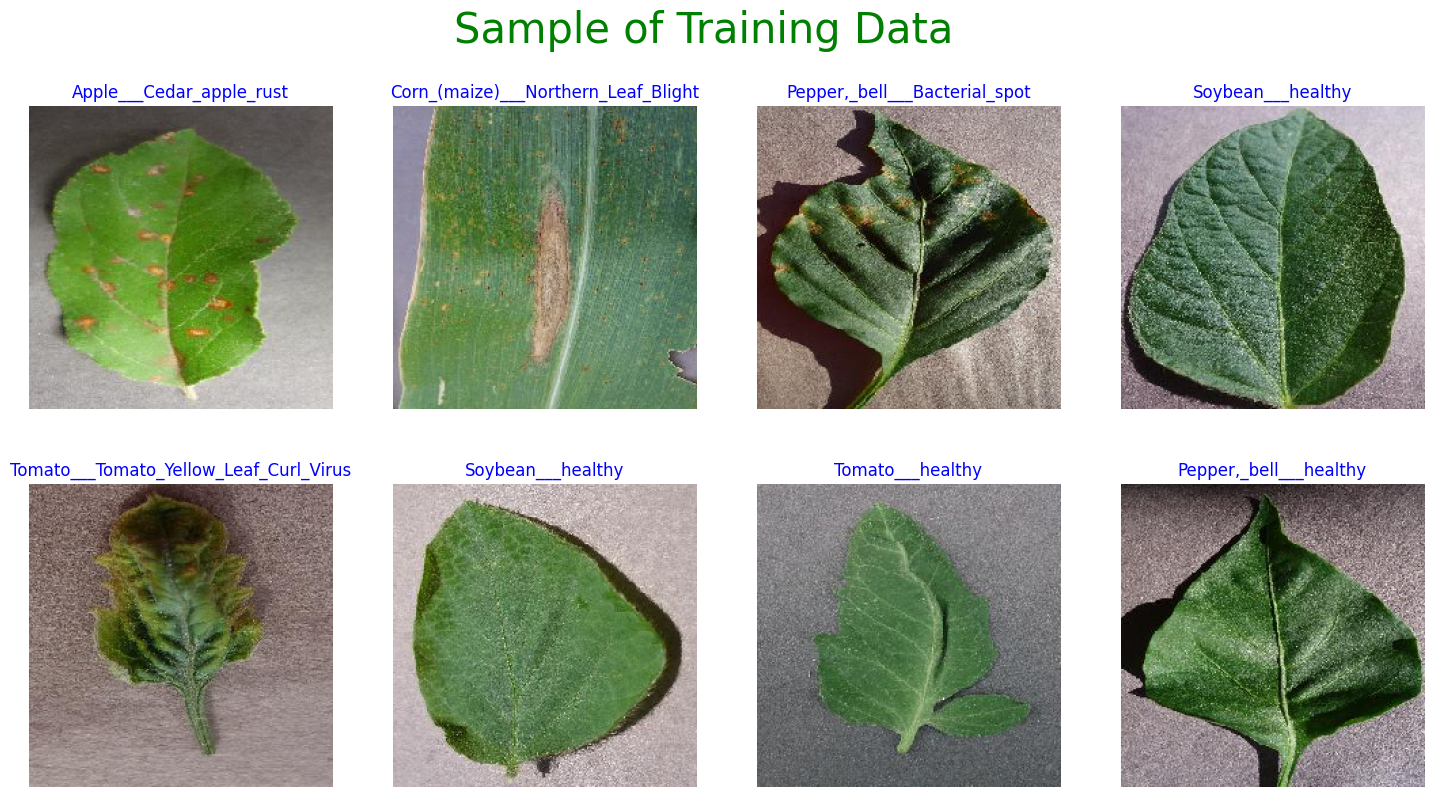

In [ ]:
show_images(train_gen)

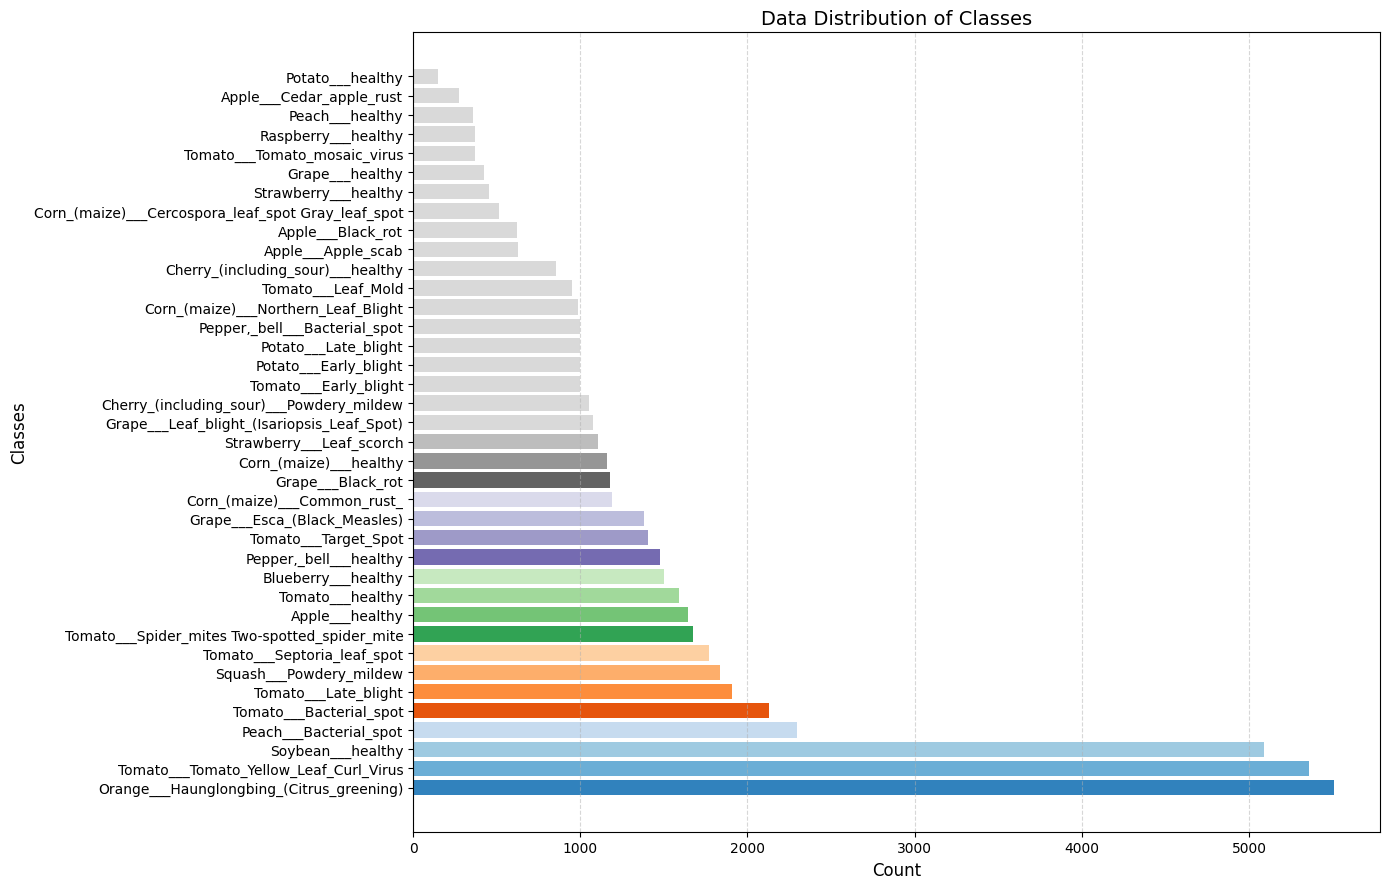

In [ ]:
class_counts = data_df['labels'].value_counts()

plt.figure(figsize=(14, 9))
colors = plt.cm.tab20c(np.arange(len(class_counts)))

plt.barh(class_counts.index, class_counts, color=colors)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Classes', fontsize=12)
plt.title('Data Distribution of Classes', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
class_count = len(list(train_gen.class_indices.keys()))

base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                           

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.ask_permission = 0  # initialize ask_permission
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        msg = 'Do you want the model to ask you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(
            ' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1

        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

                else:
                    self.count = self.count + 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc
        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            if self.ask_epoch is not None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for the number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except Exception:
                            print('Invalid')

In [ ]:
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

save_best = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch ),save_best]

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

In [ ]:
model = load_model('myModel.h5')

In [ ]:
print('Model architecture :')
visualkeras.layered_view(model)

Model architecture :


In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1087/5431 [=====>........................] - ETA: 1:58:15 - loss: 0.1519 - accuracy: 0.9973

 136/5431 [..............................] - ETA: 2:12:02 - loss: 0.1544 - accuracy: 0.9971

5431/5431 [==============================] - 223s 41ms/step - loss: 0.1495 - accuracy: 0.9982
Train Loss:  0.15191006660461426
Train Accuracy:  0.9973298907279968
--------------------
Validation Loss:  0.15438956022262573
Validation Accuracy:  0.9970533847808838
--------------------
Test Loss:  0.14950112998485565
Test Accuracy:  0.9981586933135986


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('myModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [ ]:
test_df.head()

,filepaths,labels
12994,/content/plantvillage dataset/color/Orange___H...,Orange___Haunglongbing_(Citrus_greening)
1103,/content/plantvillage dataset/color/Apple___he...,Apple___healthy
30047,/content/plantvillage dataset/color/Soybean___...,Soybean___healthy
28717,/content/plantvillage dataset/color/Soybean___...,Soybean___healthy
21774,/content/plantvillage dataset/color/Tomato___B...,Tomato___Bacterial_spot


In [ ]:
test_df.to_csv('test_df.csv', index=False)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="myModel.tflite")
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print("Model's input shape:", input_shape)

Model's input shape: [  1 224 224   3]


In [ ]:
def preprocess_image(image_path):
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)
        image = np.expand_dims(image, axis=0)
        return image

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Create and fit the LabelEncoder
le = LabelEncoder()
le.fit(test_df['labels'].unique())

# Process test images and labels
test_images = []
test_labels = []
for image_path, label in zip(test_df['filepaths'], test_df['labels']):
    preprocessed_image = preprocess_image(image_path)
    test_images.append(preprocessed_image)
    encoded_label = le.transform([label])[0]
    test_labels.append(encoded_label)

# Making predictions
predictions = []
for image in test_images:
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(np.argmax(output_data))

# Evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
report = classification_report(test_labels, predictions, target_names=le.classes_)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro-average Precision: {precision:.4f}")
print(f"Macro-average Recall: {recall:.4f}")
print(f"Macro-average F1-score: {f1:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.9976
Macro-average Precision: 0.9972
Macro-average Recall: 0.9959
Macro-average F1-score: 0.9965
Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        63
                                 Apple___Black_rot       1.00      1.00      1.00        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       1.00      1.00      1.00       165
                               Blueberry___healthy       0.99      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       105
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.92      0.95        51
                       Corn_(maize)___

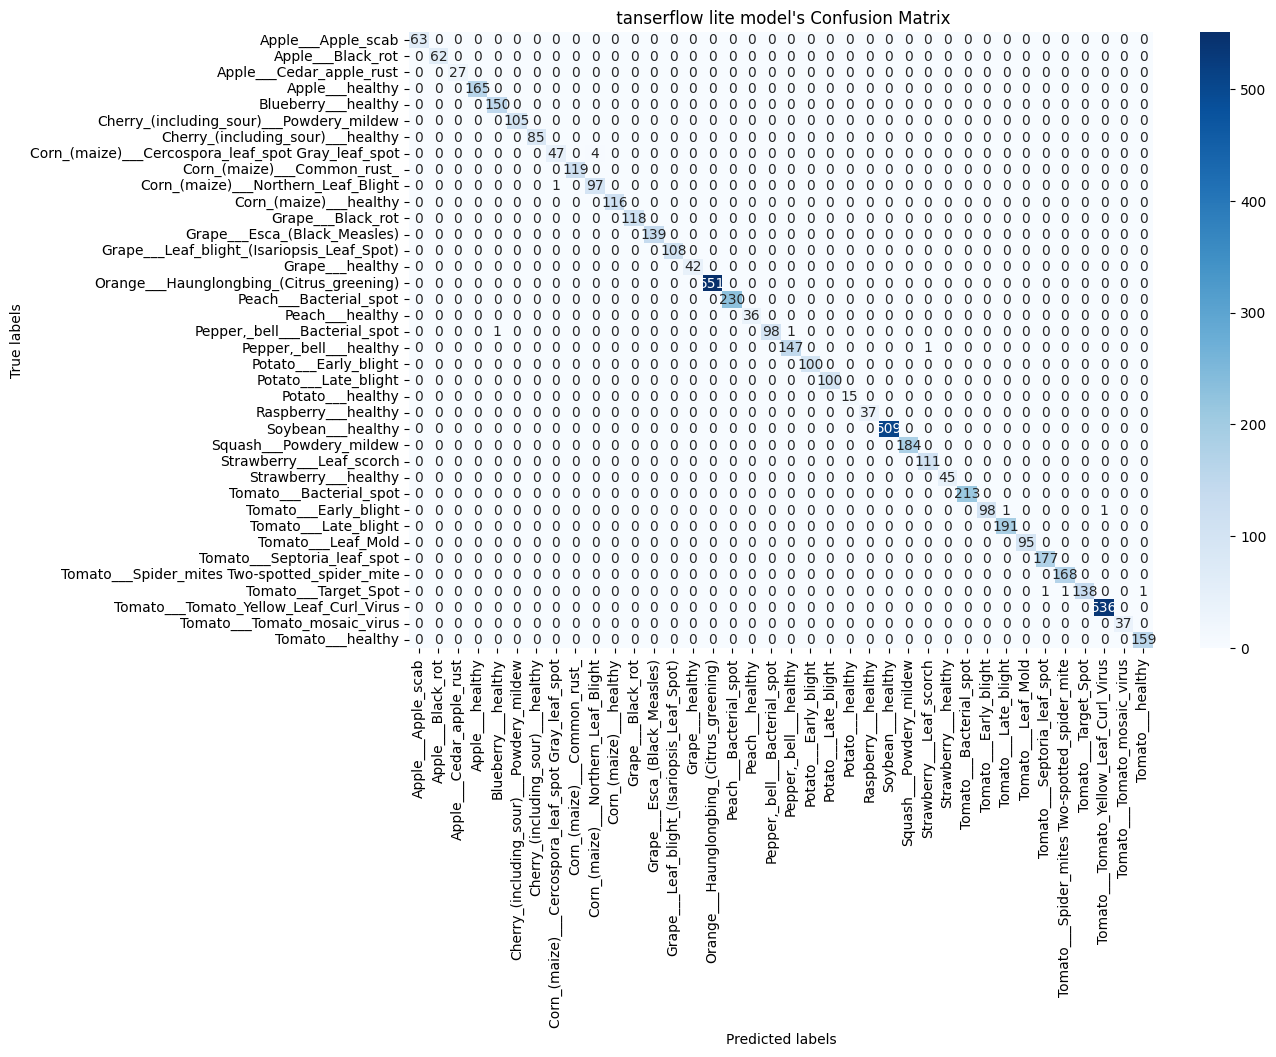

In [ ]:
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(" tanserflow lite model's Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming test_gen is a generator that yields batches of images
test_gen.reset()

y_true = test_df['labels'].to_numpy()
y_pred_proba = model.predict(test_gen)

le = LabelEncoder()
y_pred_classes = le.fit_transform(y_true)
y_pred_classes = le.inverse_transform(y_pred_proba.argmax(axis=1))

accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(
    y_true, y_pred_classes, target_names=le.classes_, output_dict=True)

report_string = classification_report(y_true, y_pred_classes, target_names=le.classes_)
print(report_string)

macro_precision = np.mean([report[label]["precision"] for label in le.classes_])
macro_recall = np.mean([report[label]["recall"] for label in le.classes_])
macro_f1 = np.mean([report[label]["f1-score"] for label in le.classes_])

print("\nMacro-average metrics:\n" f"Precision: {macro_precision:.4f}\n" f"Recall: {macro_recall:.4f}\n" f"F1-score: {macro_f1:.4f}\n" f"Accuracy: {accuracy:.4f}\n")


5431/5431 [==============================] - 235s 43ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        63
                                 Apple___Black_rot       0.98      1.00      0.99        62
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        27
                                   Apple___healthy       1.00      1.00      1.00       165
                               Blueberry___healthy       1.00      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       105
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.94      0.96        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       119
               Corn

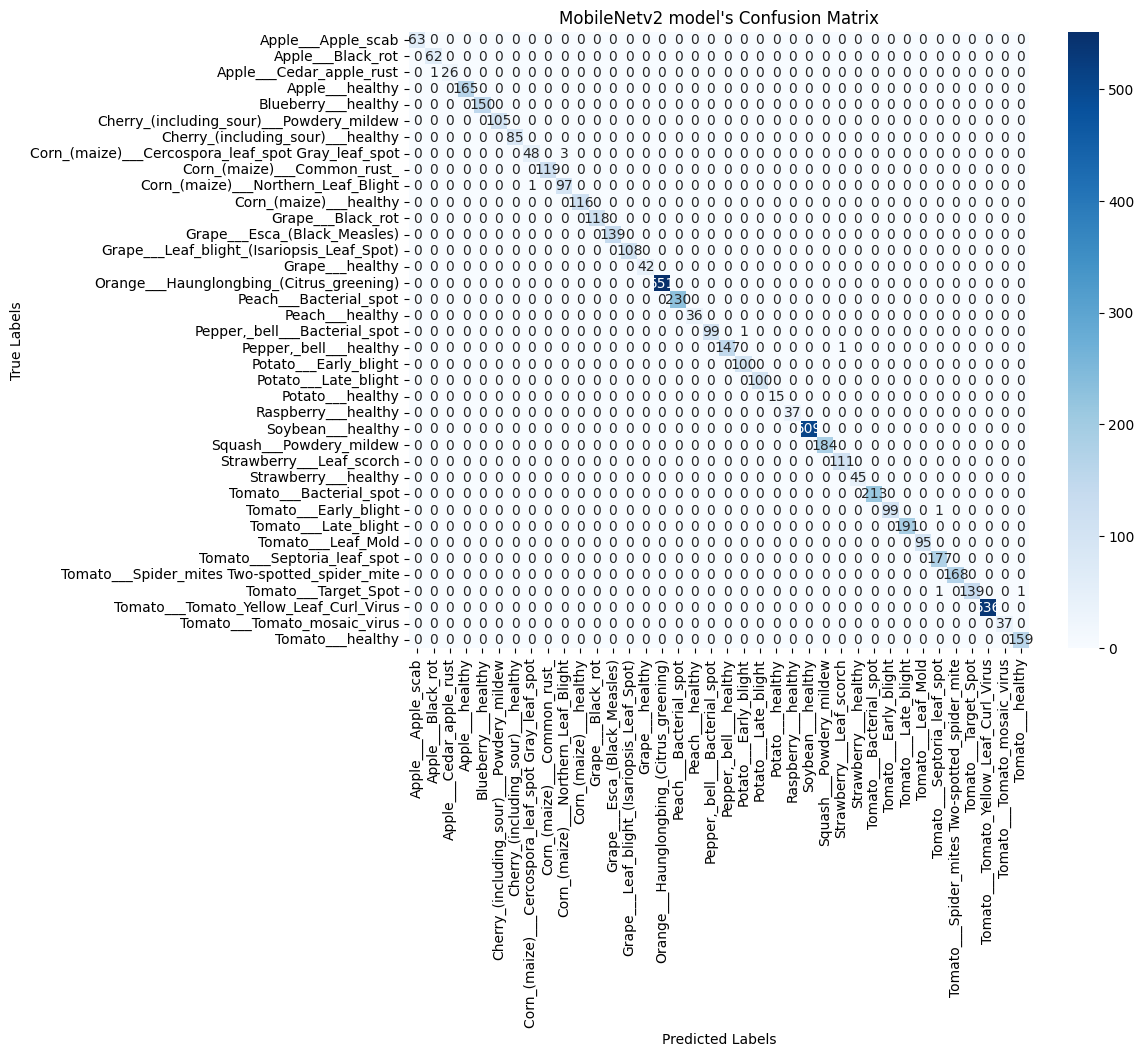

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("MobileNetv2 model's Confusion Matrix")
plt.show()

In [ ]:
image_path = "/content/plantvillage dataset/color/Corn_(maize)___Northern_Leaf_Blight/0b5eb8db-3477-488b-9cce-6a7712d895ab___RS_NLB 4232.JPG"
preprocessed_image = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
prediction = np.argmax(output_data)

le = LabelEncoder()
le.fit(test_df['labels'].unique())
predicted_class = le.inverse_transform([prediction])[0]
full_predictions = np.squeeze(output_data)

print(full_predictions)
print(prediction)
print("Predicted class:", predicted_class)


[1.4808097e-04 1.1546887e-04 6.9139111e-05 5.5065058e-04 8.0125268e-05
 3.6739402e-05 1.7638464e-04 7.3128403e-03 4.3651200e-04 9.8394048e-01
 3.3413526e-04 1.2341236e-04 7.0246380e-05 2.2010403e-05 7.7625416e-05
 7.5343146e-04 2.3450727e-04 1.7661732e-05 3.5758716e-05 6.2634856e-05
 8.5083608e-05 3.1096363e-04 3.8729126e-05 3.0329513e-05 3.4274440e-04
 6.7398598e-04 5.8524869e-04 1.4248824e-04 4.7601739e-04 3.4655747e-04
 7.1299926e-04 1.9786948e-04 2.0922195e-04 2.2431217e-04 4.2815116e-04
 4.0446175e-04 8.5792322e-05 1.0715770e-04]
9
Predicted class: Corn_(maize)___Northern_Leaf_Blight


In [ ]:
# Calculate input tensor size
input_size = 1
for dim in input_shape:
    input_size *= dim

# Print the size of the input tensor
print("Size of the input tensor:", input_size)

Size of the input tensor: 150528


In [ ]:
print(input_details[0])

{'name': 'serving_default_mobilenetv2_1.00_224_input:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [ ]:
print(output_details[0])

{'name': 'StatefulPartitionedCall:0', 'index': 180, 'shape': array([ 1, 38], dtype=int32), 'shape_signature': array([-1, 38], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
